## Loading up packages

In [1]:
# Let the program know where to find your tools file.
import sys
sys.path.append('/home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal/tools/')

In [2]:
# Load up the necessary packages 
from plastid import BAMGenomeArray, VariableFivePrimeMapFactory, \
                        GTF2_TranscriptAssembler, GFF3_TranscriptAssembler, \
                        Transcript, ThreePrimeMapFactory
import numpy as np
import os
from Bio import SeqIO
import numpy
import math
import pandas as pd
from plastid.plotting.plots import *
from scipy import stats
from scipy.stats import kstwo
from statsmodels.stats.proportion import proportions_ztest
import keegan_analysis_tools as kat
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import csv
from scipy.sparse.linalg import lsqr
from tqdm import tqdm
from multiprocess import Pool
import copy
import seaborn as sns

In [3]:
# Define the path to our data files and the path we want to save our outputs in. 
target_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/Fmr1_targets/'
ks_dmel_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/KS_stats/dmel/'
save_path = '/home/keeganfl/Desktop/Work_Fall_2021/Presentation_figures/'
samp_num = '2'

## Defining Functions

In [4]:
def split_equal(value, parts):
    value = float(value)
    return [i*value/parts for i in range(1,parts+1)]

In [5]:
def determine_enrichment(targ_ks, all_ks, N_cats, max_ks):
    ratios = []
    sections = split_equal(max_ks, N_cats)
    ratios.append(len(targ_ks.ks_stat[targ_ks.ks_stat < sections[0]])/len(all_ks.ks_stat[all_ks.ks_stat < sections[0]]))
    for sec, i in zip(sections, list(range(len(sections)))):
        try:
            ratios.append(len(targ_ks.ks_stat[(targ_ks.ks_stat > sec) & (targ_ks.ks_stat < sections[i+1])]
                )/len(all_ks.ks_stat[(all_ks.ks_stat > sec) & (all_ks.ks_stat < sections[i+1])]))
        except:
            pass
    ratios.append(len(targ_ks.ks_stat[targ_ks.ks_stat > sections[-1]])/len(all_ks.ks_stat[all_ks.ks_stat > sections[-1]]))
    return ratios, sections

In [6]:
def det_p_values(targ_ks, all_ks, sections):
    p_values = []
    for sec, i in zip(sections, list(range(len(sections)))):
        try:
            obs = len(targ_ks.ks_stat[(targ_ks.ks_stat > sec) & (targ_ks.ks_stat < sections[i + 1])])
            all_p = len(all_ks.ks_stat[(all_ks.ks_stat > sec) & (all_ks.ks_stat < sections[i + 1])])
            p_v = proportions_ztest(obs, all_p, len(targ_ks)/len(all_ks))[1]
            p_values.append(p_v)
        except:
            pass
    obs = len(targ_ks.ks_stat[targ_ks.ks_stat > sections[-1]])
    all_p = len(all_ks.ks_stat[all_ks.ks_stat > sections[-1]])
    p_v = proportions_ztest(obs, all_p, len(targ_ks)/len(all_ks))[1]
    p_values.append(p_v)
    return p_values

## Calculate the KS stat of all of the Fmr1 targets in the fly data

In [7]:
# Load up the target gene names. 
Fmr1_table = pd.read_csv(target_path + 'Fmr1_dmel_downreg_genes.txt', names = ["gene_name"])

# Load up the tables of KS statistics
df_dmel = pd.read_csv(ks_dmel_path + "ks_table_" + samp_num + ".csv")

In [8]:
# Merge the ecoli ks table with the list of gene names
Fmr1_ks_table = pd.merge(df_dmel, Fmr1_table, how='inner', right_on='gene_name', left_on='gene_ID')

In [9]:
# Keep only one copy of each gene in the Fmr1 table. 
Fmr1_ks_table.sort_values("gene_name", inplace = True)
Fmr1_ks_table.drop_duplicates(subset ="gene_name",keep = "first", inplace = True) 

(0.0, 0.7)

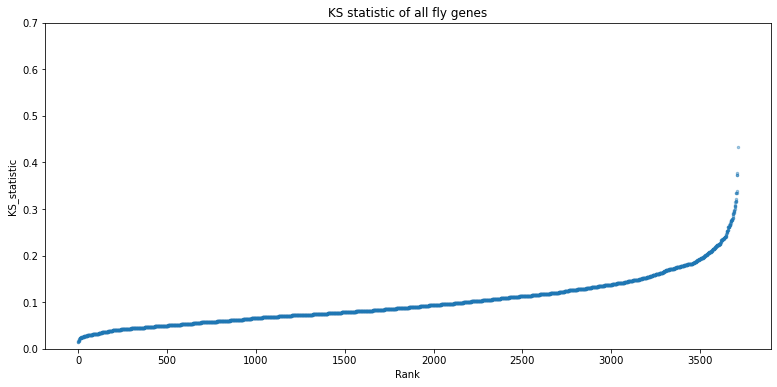

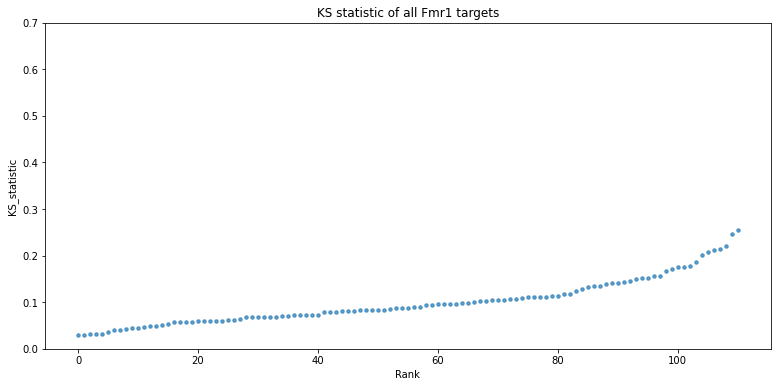

In [10]:
# Plot the KS values for each gene from lowest to highest. 
figure(figsize = (13,6))
plt.scatter(list(range(len(df_dmel["ks_stat"]))), sorted(df_dmel["ks_stat"]), s=6, alpha = 0.4)
plt.ylabel("KS_statistic")
plt.xlabel("Rank")
plt.title("KS statistic of all fly genes")
plt.ylim(0,0.7)
plt.show
figure(figsize = (13,6))
plt.scatter(list(range(len(Fmr1_ks_table["ks_stat"]))), sorted(Fmr1_ks_table["ks_stat"]), s=12, alpha = 0.7)
plt.ylabel("KS_statistic")
plt.xlabel("Rank")
plt.title("KS statistic of all Fmr1 targets")
plt.ylim(0,0.7)

In [11]:
# print out the mean of all polyprolne motif containing genes (efp targets)
print("mean KS statistic of Fmr1 target genes = " + str(np.mean(Fmr1_ks_table.ks_stat)))
print("mean KS statistic of all D.mel genes = " + str(np.mean(df_dmel.ks_stat)))

mean KS statistic of Fmr1 target genes = 0.09966276320176173
mean KS statistic of all D.mel genes = 0.10014650105075408


In [12]:
# Expected ratio without enrichment
print(len(Fmr1_ks_table.ks_stat)/len(df_dmel.ks_stat))

# Observed ratio
print(len(Fmr1_ks_table.ks_stat[Fmr1_ks_table.ks_stat > 0.15])/len(df_dmel.ks_stat[df_dmel.ks_stat > 0.15]))

0.029911075181891674
0.03136531365313653


In [13]:
max_ks = 0.15
N_cats = 2
ratios_dmel, sections_dmel = determine_enrichment(Fmr1_ks_table, df_dmel, N_cats, max_ks)

In [14]:
sections_dmel.insert(0,0)

In [15]:
det_p_values(Fmr1_ks_table, df_dmel, sections_dmel)

[0.972495511096236, 0.9365689648958062, 0.8459908431725696]

## Looking at the proportion of the targets in each KS-stat categroy

In [16]:
max_ks = 0.15
N_cats = 2
ratios_dmel, sections_dmel = determine_enrichment(Fmr1_ks_table, df_dmel, N_cats, max_ks)

In [17]:
sections_dmel

[0.075, 0.15]

In [18]:
sections_dmel.insert(0,0)

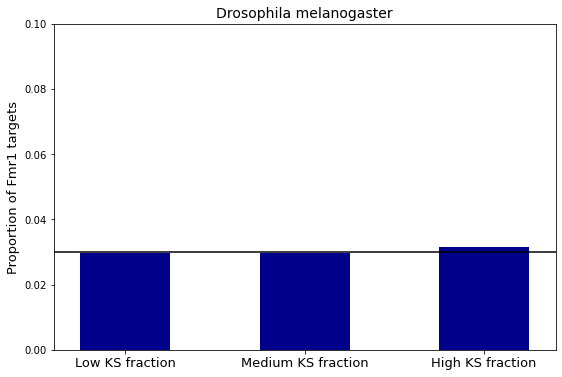

In [20]:
expected = len(Fmr1_ks_table.ks_stat)/len(df_dmel.ks_stat)
figure(figsize = (9,6))
plt.bar([1,2,3],ratios_dmel, width = 0.5, color = "darkblue",
        tick_label = ["Low KS fraction","Medium KS fraction","High KS fraction"])
plt.xticks(fontsize = 13)
plt.xlim(0.6,3.4)
plt.ylim(0, 0.1)
plt.ylabel("Proportion of Fmr1 targets", fontsize = 13)
plt.title("Drosophila melanogaster", fontsize = 14)
#plt.xlabel("KS-stat")
plt.plot([0,6],[expected,expected], color = "black")
plt.savefig(save_path + 'dmel_proportions.pdf')

## Looking at the kernel density estimates

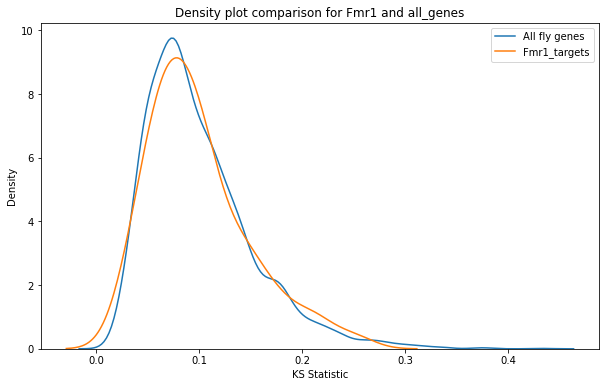

In [21]:
figure(figsize = (10,6))
sns.kdeplot(df_dmel.ks_stat, label = "All fly genes")
sns.kdeplot(Fmr1_ks_table.ks_stat, label = "Fmr1_targets")
plt.ylabel("Density")
plt.xlabel("KS Statistic")
plt.title("Density plot comparison for Fmr1 and all_genes")
plt.legend()